In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("Data/fake reviews dataset.csv")

In [2]:
# Clean up the category names
old_cat = ['Home_and_Kitchen_5', 'Sports_and_Outdoors_5', 'Electronics_5',
       'Movies_and_TV_5', 'Tools_and_Home_Improvement_5',
       'Pet_Supplies_5', 'Kindle_Store_5', 'Books_5', 'Toys_and_Games_5',
       'Clothing_Shoes_and_Jewelry_5']
new_cat = ['Home and Kitchen', 'Sports and Outdoors', 'Electronics',
        'Movies and TV', 'Tools and Home Improvement',
        'Pet Supplies', 'Kindle Store', 'Books', 'Toys and Games',
        'Clothing Shoes and Jewelry']
df['category'].replace(to_replace=old_cat, value=new_cat, inplace=True)

# Remove any duplicate rows, then check for NA values for each column
df = df.drop_duplicates(subset='text_')
df['text_'].replace(".   .                   ", np.nan, inplace=True)
df.dropna(subset=['text_'], inplace=True)

print(df.isnull().sum())

# Rename columns so that they are more descriptive
colnames_dict = {"label": "type", "text_": "comments"}
df.rename(columns=colnames_dict, inplace=True)

# Map the type column to numeric/boolean values:
  # OR (Original reviews, presumably human-created and authentic) = 0
  # CG (Computer-generated fake reviews) = 1

type_dict_map = {'OR': 0 ,'CG':1}
df['type'] = df['type'].map(type_dict_map)
df.head()

category    0
rating      0
label       0
text_       0
dtype: int64


,category,rating,type,comments
0,Home and Kitchen,5.0,1,"Love this! Well made, sturdy, and very comfor..."
1,Home and Kitchen,5.0,1,"love it, a great upgrade from the original. I..."
2,Home and Kitchen,5.0,1,This pillow saved my back. I love the look and...
3,Home and Kitchen,1.0,1,"Missing information on how to use it, but it i..."
4,Home and Kitchen,5.0,1,Very nice set. Good quality. We have had the s...


Number of type 0 reviews: 20215
Number of type 1 reviews: 20196


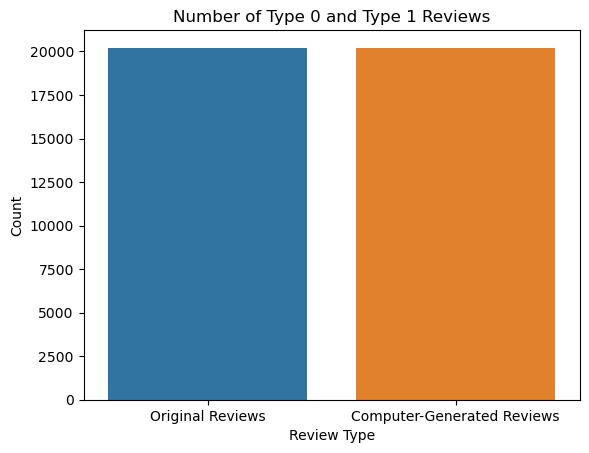

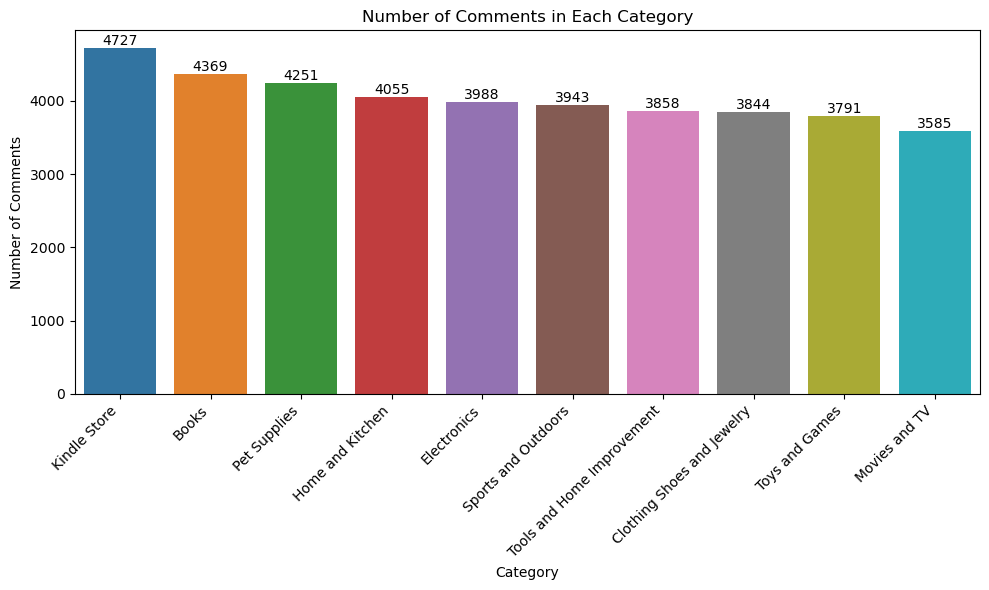

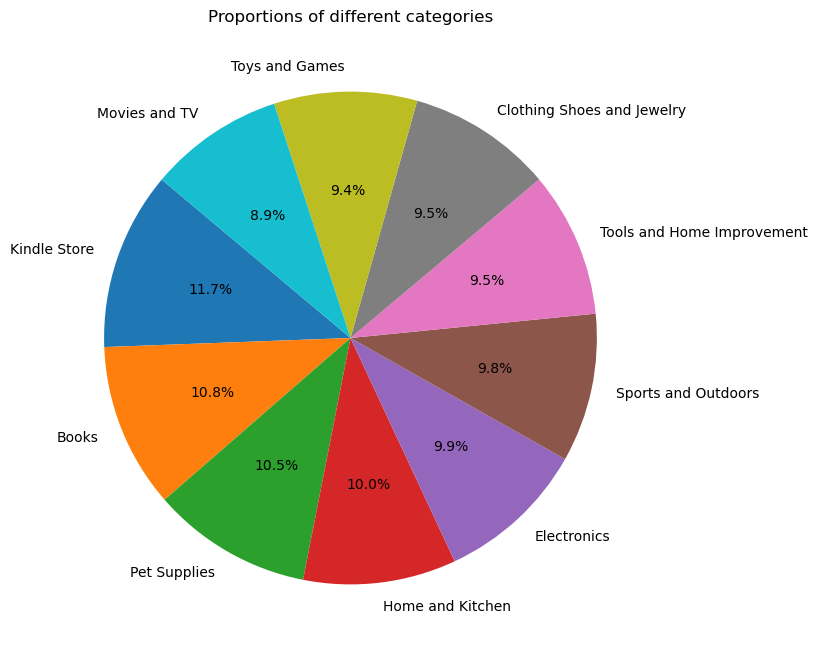

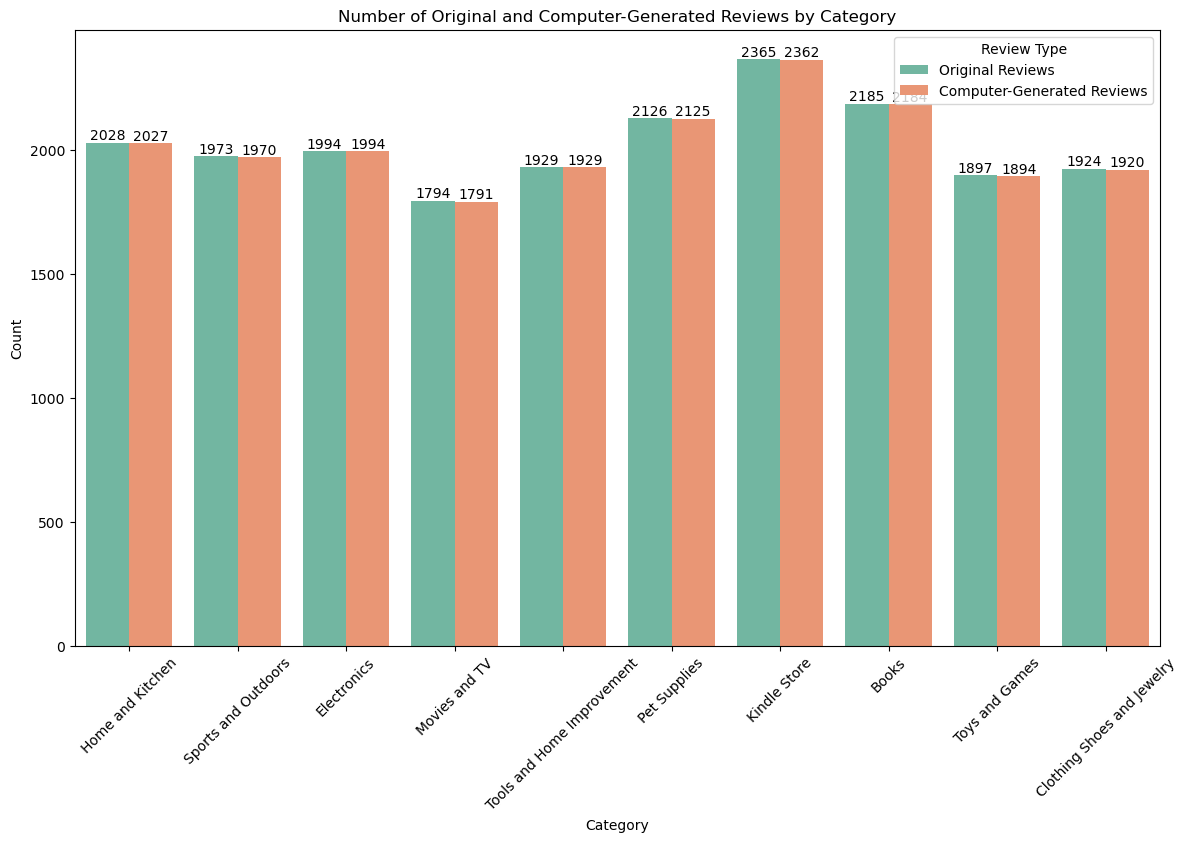

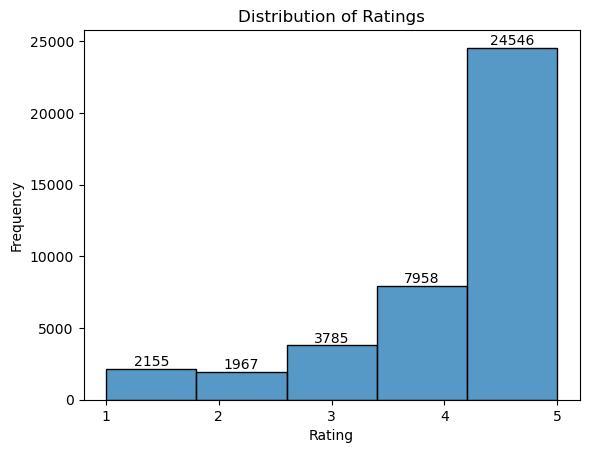

rating  type
1.0     0        1092
        1        1063
2.0     0        1005
        1         962
3.0     0        1834
        1        1951
4.0     0        4045
        1        3913
5.0     0       12239
        1       12307
dtype: int64


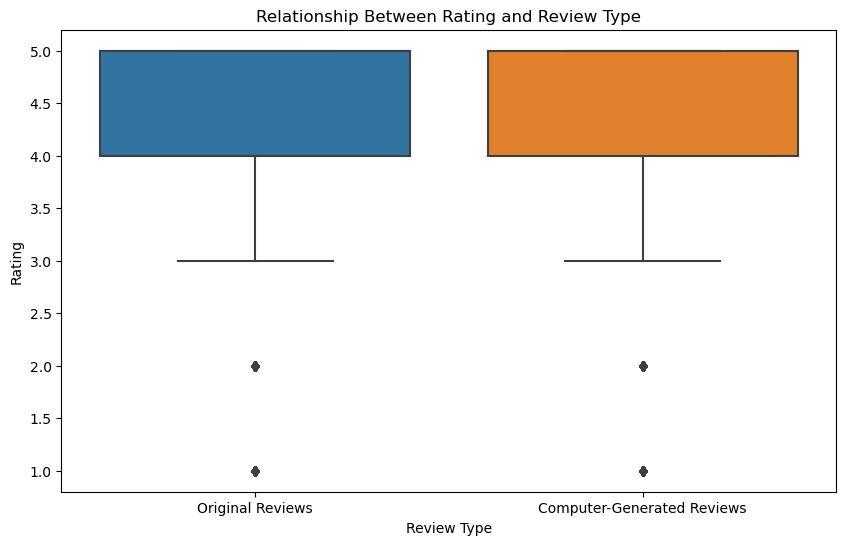

In [3]:
# Print the review counts for each types
type_counts = df['type'].value_counts()
print("Number of type 0 reviews:", type_counts[0])
print("Number of type 1 reviews:", type_counts[1])

#Numbers of review in each type
sns.countplot(data=df,x='type')
plt.title('Number of Type 0 and Type 1 Reviews')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Original Reviews', 'Computer-Generated Reviews'])
plt.show()

# Numbers of comment in each category
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Number of Comments in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in barplot.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom')
plt.show()

#Proportions of different categories
plt.figure(figsize=(8, 8))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Proportions of different categories')
plt.ylabel('')
plt.show()

#Types of review in each category
plt.figure(figsize=(14, 8))
bars =sns.countplot(data=df, x='category', hue='type', palette='Set2')
plt.title('Number of Original and Computer-Generated Reviews by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.legend(title='Review Type', labels=['Original Reviews', 'Computer-Generated Reviews'])
for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}',
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom')
plt.show()

#Rating distribution
hist=sns.histplot(data=df, x='rating', bins=5,)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
for p in hist.patches:
    hist.annotate(f'{int(p.get_height())}', 
                  (p.get_x() + p.get_width() / 2, p.get_height()), 
                  ha='center', va='bottom')
plt.show()

# the number of different types reviews by rating
review_counts = df.groupby(['rating', 'type']).size()
print(review_counts)

plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='rating', data=df)
plt.title('Relationship Between Rating and Review Type')
plt.xlabel('Review Type')
plt.ylabel('Rating')
plt.xticks([0, 1], ['Original Reviews', 'Computer-Generated Reviews'])

plt.show()


In [4]:

target_var  = 'type'
feature_var = [ 'rating', 'comments']
X = df[feature_var]
y = df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=101)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28287, 2)
(12124, 2)
(28287, 1)
(12124, 1)


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Define the pipeline
pipeline_nb = Pipeline([
    # Remove the max_features limitation at the end.
    ('tfidf', TfidfVectorizer(max_features=20000)),  # TF-IDF vectorizer
    ('classifier', GaussianNB())    # Gaussian Naive Bayes classifier
])

# Transform comment to tfidf
X_train_tfidf = pipeline_nb.named_steps['tfidf'].fit_transform(X_train['comments'])
X_test_tfidf = pipeline_nb.named_steps['tfidf'].fit_transform(X_test['comments'])

X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Cross validation
kfold = KFold(n_splits=5, shuffle=False, random_state=None)
rkfold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)

params = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}
model = GaussianNB()

grid_nb = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=5, verbose=1)

# Fit the function to train set 
grid_nb.fit(X_train_tfidf, y_train)

# Find the best parameter and see how well it performs on test set
print(grid_nb.best_params_)
print(grid_nb.score(X_test_tfidf, y_test))
print(grid_nb.cv_results_['mean_test_score'])


# Below are code for validation
# print('kFold accuracy scores are', cross_val_score(pipeline_nb.named_steps['classifier'], X_train_tfidf, y_train, scoring='precision', cv= kfold, n_jobs=-1))
# print('repeated kFold accuracy scores are', cross_val_score(pipeline_nb.named_steps['classifier'], X_train_tfidf, y_train, scoring='precision', cv= rkfold, n_jobs=-1))

# print('The average KFold scores is', np.mean(cross_val_score(pipeline.named_steps['classifier'], X_train_tfidf, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)))
# print('The average RepeatedKFold score is', np.mean(cross_val_score(pipeline.named_steps['classifier'], X_train_tfidf, y_train, cv=rkfold, n_jobs=-1)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Chris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Chris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Chris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Chris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

{'var_smoothing': 0.0001}
0.4989277466182778
[0.74458255 0.74546634 0.74642075 0.74825907 0.75020343 0.76459158
 0.74999107 0.52600129]


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Define the pipeline
pipeline_nb = Pipeline([
    # Remove the max_features limitation at the end.
    ('tfidf', TfidfVectorizer(max_features=20000)),  # TF-IDF vectorizer
    ('classifier', GaussianNB(var_smoothing=0.002))    # Gaussian Naive Bayes classifier
])
# Transform comment to tfidf
X_train_tfidf = pipeline_nb.named_steps['tfidf'].fit_transform(X_train['comments'])
X_test_tfidf = pipeline_nb.named_steps['tfidf'].fit_transform(X_test['comments'])

X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

model_nb = pipeline_nb.named_steps['classifier'].fit(X_train_tfidf, y_train.ravel())

# Evaluate the model
train_accuracy = pipeline_nb.named_steps['classifier'].score(X_train_tfidf, y_train)
test_accuracy = pipeline_nb.named_steps['classifier'].score(X_test_tfidf, y_test)

feature_names =  pipeline_nb.named_steps['tfidf'].get_feature_names_out()
num_features = len(feature_names)

print("Number of features (vocabulary size):", num_features)
print("This accuracy score shows")
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

predict_nb = model_nb.predict(X_test_tfidf)

acc = accuracy_score(predict_nb, y_test)
precision = precision_score(predict_nb, y_test)
recall = recall_score(predict_nb, y_test)
f1 = f1_score(predict_nb, y_test)

print('The accuracy score of NB is', acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Number of features (vocabulary size): 20000
This accuracy score shows
Training Accuracy: 0.8052815781100859
Testing Accuracy: 0.5072583305839656
The accuracy score of NB is 0.5072583305839656
Precision: 0.061164090759618546
Recall: 0.5849056603773585
F1 Score: 0.11074724620422743


In [ ]:
from sklearn.metrics import accuracy_score

# Ask for user input
rating = int(input("Enter the rating (1-5): "))
comment = input("Enter the comment: ")

# Create a DataFrame with the user input
user_data = pd.DataFrame({'rating': [rating],
                          'comments': [comment]})

# Transform the user input using the TF-IDF vectorizer
user_data_tfidf = pipeline.named_steps['tfidf'].transform(user_data['comments'])

# Predict the output using the trained classifier
prediction = pipeline.named_steps['classifier'].predict(user_data_tfidf.toarray())

# Calculate accuracy if actual output is available
# OR (Original reviews, presumably human-created and authentic) = 0
# CG (Computer-generated fake reviews) = 1
actual_output = 0  
accuracy = accuracy_score([actual_output], prediction)
# Print the prediction and accuracy
if prediction[0] == 0:
    print("Original review (OR)")
else:
    print("Computer-generated fake review (CG)")

print("Prediction Accuracy:", accuracy)

<br>
<br>
<br>
<br>
<br>
Below are backup code that didn't really work


In [ ]:
#Transform each comment row into tfidf array
df['comments'] = df['comments'].astype(str)

vectorizer = TfidfVectorizer()
# print(df['comments'])
for index, row in df.iterrows():
    # Transform the comment into a TF-IDF array
    comment = row['comments']
    # Check if the comment is empty or contains only stop words
    

    # Transform the comment into a TF-IDF array
    comment_tfidf = vectorizer.fit_transform([comment]).toarray()
    # Replace the original comment with its TF-IDF array
    df.at[index, 'comments'] = comment_tfidf

# response = vectorizer.fit_transform(df['comments'])
# df['comments'] = response.getnnz()


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

# Initialize the Naive Bayes classifier
model = GaussianNB()
print("error1")
# Train the classifier
model.fit(X_train, y_train)
print("error2")

# Predictions on the training set
train_preds = model.predict(X_train)
print("error3")

# Predictions on the testing set
test_preds = model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
